In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")
from tapm import bigmodel_STI
import icomo
import numpy as np
import copy
from matplotlib.colors import LogNorm

In [5]:

def compute_sti_infections(
    Hs, Ps, lambda_P_values, args, y0_in, filename=None
):
    """
    Compute STI infections for given H, P, and lambda_P values and store the results for different H values.

    Parameters:
    Hs (list): List of H values.
    Ps (list): List of P values.
    lambda_P_values (list): List of lambda_P values.
    y0 (dict): Initial state of the system.
    args (dict): Arguments for the model.
    integrator (function): Function to integrate the model.
    model_STI (module): Module containing STI model functions.
    filename (str): Name of the file to save the results.

    Returns:
    dict: Results for different H values.
    """
    # Dictionary to store results for different H values
    results = {}

    # Loop over each value of H
    for H in Hs:
        args_mod = args.copy()
        args_mod["H"] = H
        # Determine the size of the result matrices
        res_size = [len(lambda_P_values), len(Ps)]

        # Initialize result matrices
        res_Ia = np.zeros(res_size)  # Asymptomatic STI infections
        res_Is = np.zeros(res_size)  # Symptomatic STI infections
        res_T = np.zeros(res_size)  # Treated STI infections
        res_S = np.zeros(res_size)
        res_prevalance = np.zeros(res_size)  # Total infections
        check = np.zeros(res_size)  # Convergence check
        check_1 = np.zeros(res_size)

        # Loop over each lambda_P value
        for i, lambda_P in enumerate(lambda_P_values):
            for j, P in enumerate(Ps):
                args_mod["P"] = P
                args_mod["lambda_P"] = lambda_P

                #print(f"Running for H={H}, P={P}, lambda_P={lambda_P}, y0={y0_in}")
                
                output = icomo.diffeqsolve(
                    args = args_mod,
                    ODE = bigmodel_STI.main_model,
                    y0 = y0_in,
                    ts_out = np.linspace(0, 365*80, 365*80+1),
                    max_steps=365*80+1)

                # Get the final state of the system
                y1 = {key: value[-1] for key, value in output.ys.items()}
                y2 = {key: value[-5] for key, value in output.ys.items()}
                #check convergence by comparing last value to fifth last value
                for key in y1:
                    if not np.allclose(y1[key], y2[key], rtol=0, atol=1e-8):
                        print(f"Convergence failed: {key}: (diff = {abs(y1[key] - y2[key])})")
                
                # Record the final susceptible individuals
                res_S[i, j] = jnp.sum(y1["S_STI"])

                # Record the final asymptomatic STI infections
                res_Ia[i, j] = jnp.sum(y1["Ia_STI"])

                # Record the final symptomatic STI infections
                res_Is[i, j] = jnp.sum(y1["Is_STI"])

                # Record the final treated STI infections
                res_T[i, j] = jnp.sum(y1["T_STI"])


                # Calculate total new infections
                res_prevalance[i, j] = res_Ia[i, j] + res_Is[i, j] 


                check_1[i, j] = res_S[i, j] + res_Ia[i, j] + res_Is[i, j] + res_T[i, j] 


        # Store the results for the current H value
        results[H] = {
            "res_S": res_S,
            "res_Ia": res_Ia,
            "res_Is": res_Is,
            "res_T": res_T,
            "res_infections": res_prevalance,
            "check": check,
            "check_1": check_1,
        }


    # Save the results to a file
    
    
    #if filename:
    #    utils.save_results(results, filename)

    return results



# Define the parameters
Hs = np.linspace(0.0, 0.2, 11)
Ps = np.linspace(0, 1, 11)
lambda_P_values = np.array([1.0, 2.0, 4.0]) / 365.0
args = bigmodel_STI.args
result_prevalance = compute_sti_infections(Hs, Ps, lambda_P_values, args, bigmodel_STI.y0, filename=None)

In [5]:
result_prevalance

{0.0: {'res_S': array([[0.86634233, 0.89715933, 0.91765614, 0.93183744, 0.94206414,
          0.94971742, 0.95562772, 0.9603135 , 0.964111  , 0.96724607,
          0.96987524],
         [0.86634233, 0.91765614, 0.94206414, 0.95562772, 0.964111  ,
          0.96987524, 0.97403183, 0.97716461, 0.97960738, 0.98156397,
          0.98316556],
         [0.86634233, 0.94206414, 0.964111  , 0.97403183, 0.97960738,
          0.98316556, 0.9856294 , 0.98743501, 0.98881453, 0.98990265,
          0.9907828 ]]),
  'res_Ia': array([[0.13263746, 0.10176172, 0.08124633, 0.0670621 , 0.05683855,
          0.04919069, 0.0432865 , 0.03860684, 0.0348152 , 0.03168563,
          0.02906158],
         [0.13263746, 0.08124633, 0.05683855, 0.0432865 , 0.0348152 ,
          0.02906158, 0.02491415, 0.02178926, 0.01935336, 0.01740283,
          0.01580663],
         [0.13263746, 0.05683855, 0.0348152 , 0.02491415, 0.01935336,
          0.01580663, 0.01335204, 0.01155419, 0.01018135, 0.00909913,
          0.0082242

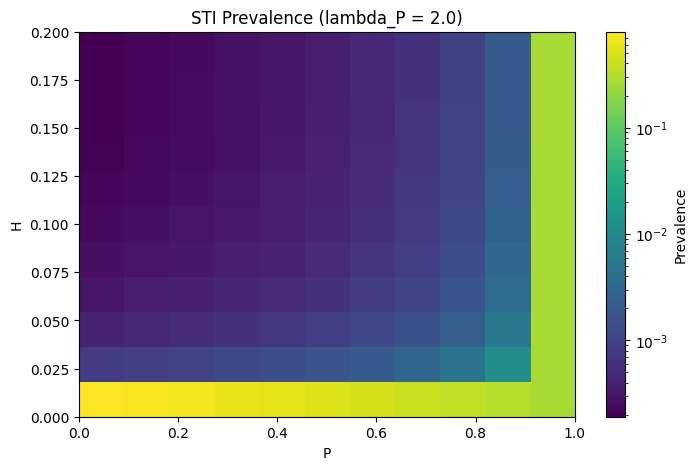

In [14]:

# Select the index of lambda_P_values
lambda_P_idx = 1

# Create a prevalence matrix for heatmap: rows=Hs, columns=Ps
prevalence_matrix = np.zeros((len(Hs), len(Ps)))

for i, H in enumerate(Hs):
    # Each H value is used as a key, we take only the desired lambda_P index row
    prevalence_matrix[i, :] = result_prevalance[H]["res_infections"][lambda_P_idx,:]

plt.figure(figsize=(8, 5))
im = plt.imshow(
    prevalence_matrix, 
    aspect='auto',
    extent=[Ps[0], Ps[-1], Hs[0], Hs[-1]],    # Y axis = H from low to high
    origin='lower',                           # H increases upward (lower = H[0])
    cmap='viridis',
    #vmax = 0.7
    norm=LogNorm(vmin=prevalence_matrix.min(), vmax=prevalence_matrix.max())
)
plt.colorbar(im, label='Prevalence')
plt.xlabel("P")
plt.ylabel("H")
plt.title(f"STI Prevalence (lambda_P = {lambda_P_values[lambda_P_idx]*365})")
plt.show()

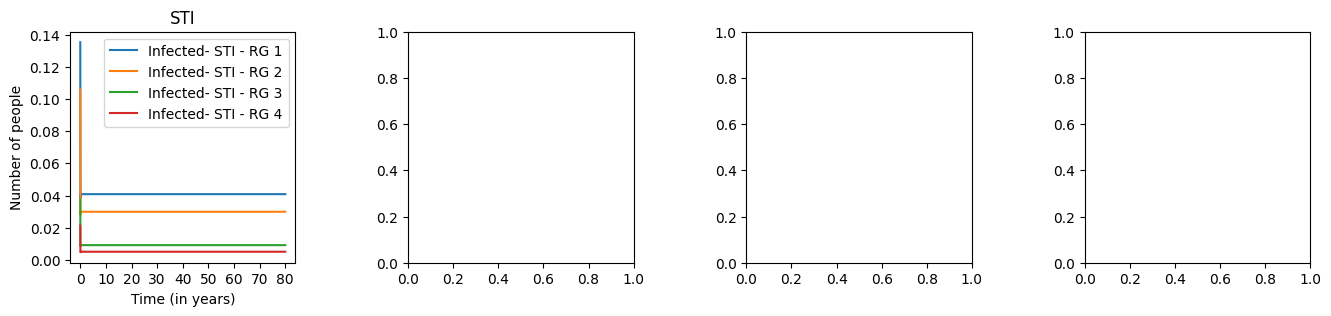

In [3]:

fig, axes = plt.subplots(1, 4, figsize=(16,3))
fig.subplots_adjust(wspace=0.5)

def number_of_people(comps, risk_group):
    total = 0
    for comp in comps:
        total += output.ys[comp][:,risk_group]
    return total

# STI
ax = axes[0]
for i in range(output.ys["Is_STI"].shape[1]):
    ax.plot(number_of_people(comps=("Is_STI", "Ia_STI"), risk_group=i), label="Infected- STI - RG "+str(i+1))

ax.set_xticks(np.arange(0, 365*80+1, 365*10))
ax.set_xticklabels(np.arange(0, 81, 10))
#ax.set_ylim(0, 0.1)
ax.set_ylabel("Number of people")
ax.set_xlabel("Time (in years)")
ax.set_title("STI")
ax.legend()

# HIV
ax = axes[1]
# ART per risk group
#for i in range(output.ys["A1"].shape[1]): # go through all risk groups
#    ax.plot(number_of_people(comps=("A1", "A2", "A3", "A4"), risk_group=i), label="ART - RG "+str(i+1)) # add all disease stages together

# I per risk group 
#for i in range(output.ys["I1"].shape[1]):
#    ax.plot(number_of_people(comps=("IP", "I1", "I2", "I3", "I4"), risk_group=i), label="Infected - RG "+str(i+1))

# ART and I per risk group = Prevalence
# for i in range(output.ys["I1"].shape[1]):
#     ax.plot(number_of_people(comps=("A1", "A2", "A3", "A4", "IP", "I1", "I2", "I3", "I4"), risk_group=i), label="Prevalence - RG "+str(i+1))


# ax.set_xticks(np.arange(0, 365*80+1, 365*10))
# ax.set_xticklabels(np.arange(0, 81, 10))
# ax.set_ylim(0, 0.08)
# ax.set_ylabel("Number of people")
# ax.set_xlabel("Time (in years)")
# ax.set_title("HIV")
# ax.legend()

# # HIV deaths
# ax = axes[2]
# ax.plot(output.ys["D"], label="Deaths - RG "+str(i+1))
# ax.legend()
# ax.set_xticks(np.arange(0, 365*80+1, 365*10))
# ax.set_xticklabels(np.arange(0, 81, 10))
# ax.set_ylabel("HIV Deaths")

# # hazard
# ax = axes[3]
# all_ART_keys = ["A1","A2","A3","A4"]
# all_HIV_keys = ["S","SP","I1","I2","I3","I4","IP"] + all_ART_keys
# all_STI_keys = ["S_STI","Ia_STI","Is_STI","T_STI"]
# sum_vector = 0
# compartment_matrix = 0
# for i in range(output.ys["A1"].shape[1]):
#     sum_vector += jnp.sum(jnp.array([output.ys[k][:,i] for k in all_HIV_keys]), axis=0)

# for i in range(output.ys["A1"].shape[1]):
#     compartment_matrix += jnp.sum(jnp.array([output.ys[key][:,i] for key in all_ART_keys]), axis=0)  # Shape: (len(all_ART_keys), time_points)
# hazard_vector = compartment_matrix / sum_vector * 100   # Vectorized hazard computation

# ax.scatter(range(len(hazard_vector)), hazard_vector, color="black", s=1)

# ax.set_xticks(np.arange(0, 365*80+1, 365*10))
# ax.set_xticklabels(np.arange(0, 81, 10))
# ax.set_ylabel("Hazard (%)")
# ax.set_xlabel("Time (in years)")

# # print for each compartment in output the last time value
# HIV_sum_at_end = [0,0,0,0]
# STI_sum_at_end = [0,0,0,0]
# HIV_sum_at_start = [0,0,0,0]
# STI_sum_at_start = [0,0,0,0]

# for key, value in output.ys.items():
#     print(key, value[-1]*210000)

# for key in (all_HIV_keys + ["D"]):
#     for i in range(4):
#         HIV_sum_at_end[i] += output.ys[key][-1,i]
#         HIV_sum_at_start[i] += output.ys[key][0,i]
# for key in (all_STI_keys + ["D_STI"]):
#     for i in range(4):
#         STI_sum_at_end[i] += output.ys[key][-1,i]
#         STI_sum_at_start[i] += output.ys[key][0,i]
# print("HIV sum at start", HIV_sum_at_start)
# print("STI sum at start", STI_sum_at_start)
# print("HIV sum at end", HIV_sum_at_end)
# print("STI sum at end", STI_sum_at_end)

2
-----------
{0.1: {'res_S': 1, 'res_Ia': [2, 3], 'res_Is': 4, 'res_T': 4, 'res_infections': [6, 7, 8, 9]}, 0.5: {'res_S': 1, 'res_Ia': [2, 3], 'res_Is': 4, 'res_T': 4, 'res_infections': [6, 7, 8, 9]}, 1: {'res_S': 1, 'res_Ia': [2, 3], 'res_Is': 4, 'res_T': 4, 'res_infections': [6, 7, 8, 9]}, 2: {'res_S': 1, 'res_Ia': [2, 3], 'res_Is': 4, 'res_T': 4, 'res_infections': [6, 7, 8, 9]}}
